# Introduction to Neural Networks

In [1]:
import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset
- x is for the inputs (images of handwritten digits)
- y is for the labels or outputs (digits 0-9)

The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


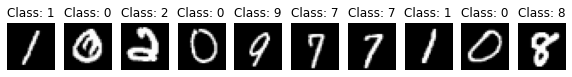

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Linear Model
The linear layers in PyTorch perform a basic $xW + b$.


Loss function: Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

Optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd)

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- Using few epochs can lead to underfitting and using too many can lead to overfitting.

In [8]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

/home/cjcurry/ai-science-training-series/.venv/lib64/python3.6/site-packages/torch/autograd/__init__.py:156: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Epoch 0: training loss: 0.5019869073232015, accuracy: 87.62708333333333
Epoch 0: val. loss: 0.4950529140360812, val. accuracy: 87.675
Epoch 1: training loss: 0.4213678871790568, accuracy: 89.01458333333333
Epoch 1: val. loss: 0.4127162168634699, val. accuracy: 88.83333333333333
Epoch 2: training loss: 0.3873736116886139, accuracy: 89.68958333333333
Epoch 2: val. loss: 0.37807178529019053, val. accuracy: 89.50833333333334
Epoch 3: training loss: 0.3674150980313619, accuracy: 90.11666666666667
Epoch 3: val. loss: 0.357876792233041, val. accuracy: 89.86666666666666
Epoch 4: training loss: 0.35385008676846824, accuracy: 90.41875
Epoch 4: val. loss: 0.3442757912772767, val. accuracy: 90.2


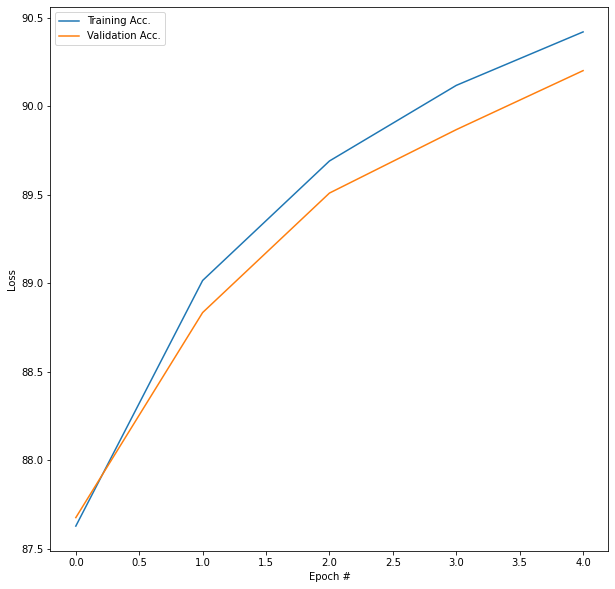

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

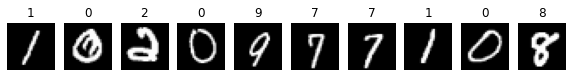

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#create dataloader for test data
# The dataloader makes our dataset iterable 
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3324, test accuracy: 90.81%


In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


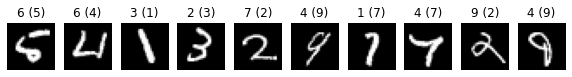

In [17]:
show_failures(linear_model, test_dataloader)

# Multilayer Model

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

In [18]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.9485474330584208, accuracy: 71.32291666666667
Epoch 0: val. loss: 0.9381290769323389, val. accuracy: 71.64166666666667
Epoch 1: training loss: 0.4054250284433365, accuracy: 88.47291666666666
Epoch 1: val. loss: 0.3957584839552007, val. accuracy: 88.55
Epoch 2: training loss: 0.3115564306974411, accuracy: 90.96666666666667
Epoch 2: val. loss: 0.3041186565731434, val. accuracy: 90.81666666666666
Epoch 3: training loss: 0.2633356321255366, accuracy: 92.30833333333334
Epoch 3: val. loss: 0.2571234740316868, val. accuracy: 92.34166666666667
Epoch 4: training loss: 0.21842029376824698, accuracy: 93.73541666666667
Epoch 4: val. loss: 0.21680487224713285, val. accuracy: 93.53333333333333


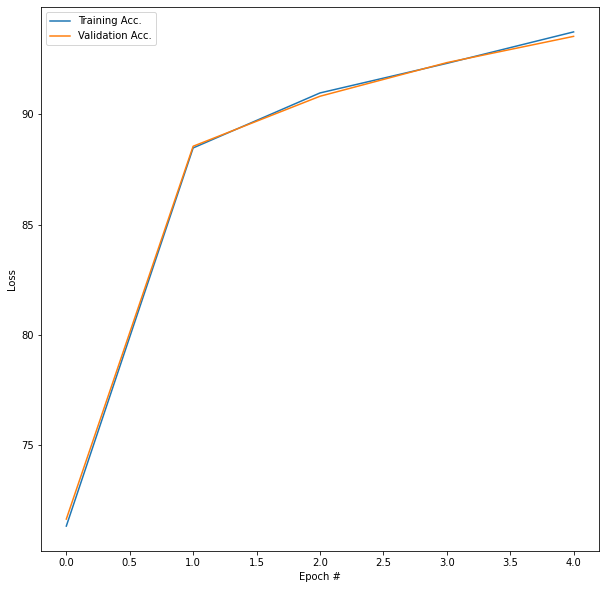

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


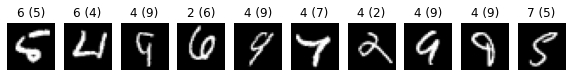

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

2. Bonus: What is a learning rate scheduler?

### 1) Comparing with different hyperparameters
#### a) batch sizes

In [23]:
batch_sizes = [32,64,128,256]

train_batch_acc = []
val_batch_acc = []

for batch_size in batch_sizes:

    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    train_batch_acc.append(train_acc_all)
    val_batch_acc.append(train_acc_all)

Epoch 0: training loss: 0.27970189874743423, accuracy: 91.79791666666667
Epoch 0: val. loss: 0.2778357878526052, val. accuracy: 91.625
Epoch 1: training loss: 0.18403406391354898, accuracy: 94.5875
Epoch 1: val. loss: 0.18908572147289912, val. accuracy: 94.325
Epoch 2: training loss: 0.13789792386007807, accuracy: 95.93958333333333
Epoch 2: val. loss: 0.14749564968049525, val. accuracy: 95.59166666666667
Epoch 3: training loss: 0.12087980259923885, accuracy: 96.36875
Epoch 3: val. loss: 0.1347445158312718, val. accuracy: 95.90833333333333
Epoch 4: training loss: 0.10225993837974966, accuracy: 96.89791666666666
Epoch 4: val. loss: 0.12309079803215961, val. accuracy: 96.20833333333333
Epoch 0: training loss: 0.4073391429583232, accuracy: 88.47916666666666
Epoch 0: val. loss: 0.3998880602736422, val. accuracy: 88.47500000000001
Epoch 1: training loss: 0.2619347894191742, accuracy: 92.38333333333333
Epoch 1: val. loss: 0.26086220608905275, val. accuracy: 92.20833333333334
Epoch 2: training

From the batch sizes,32,64,128, and 256; 32 had the best accuracy.

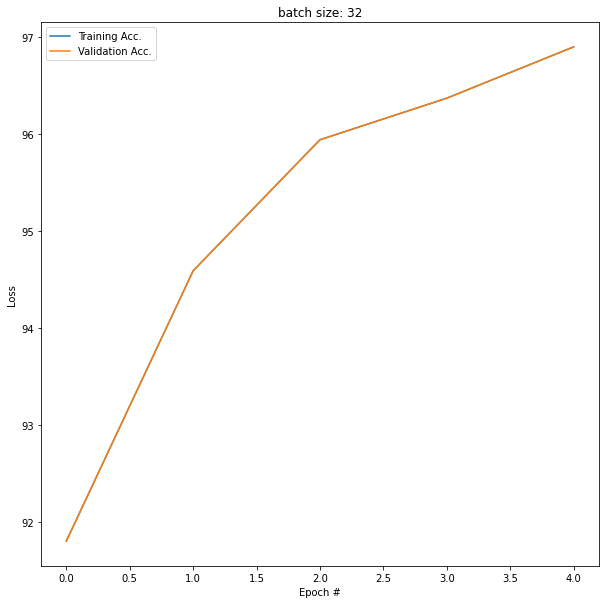

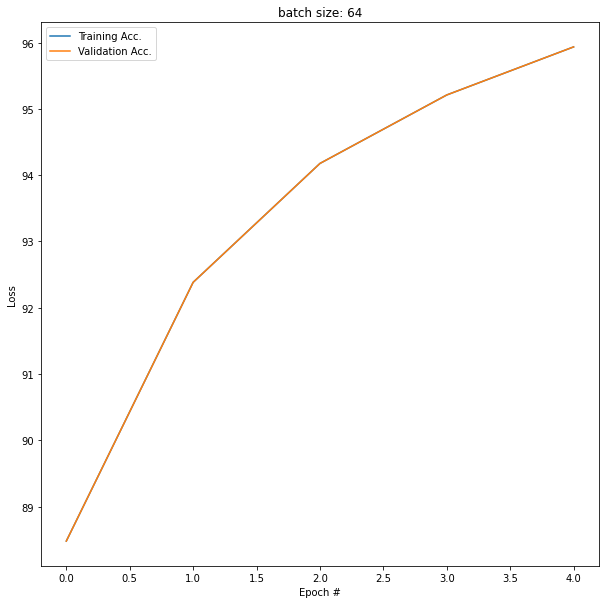

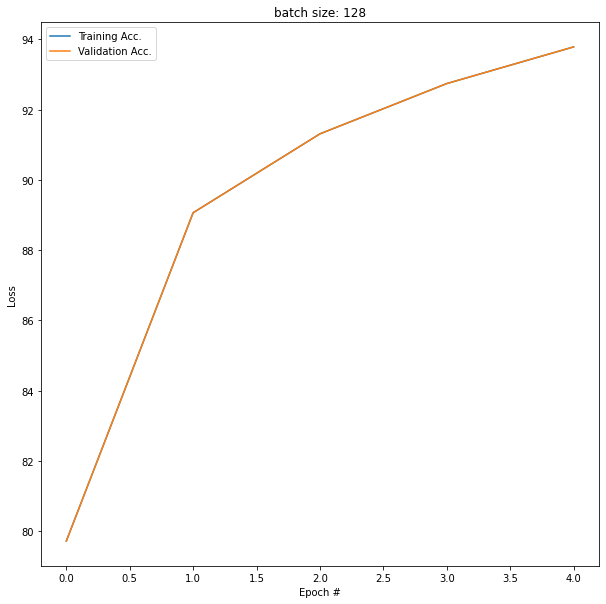

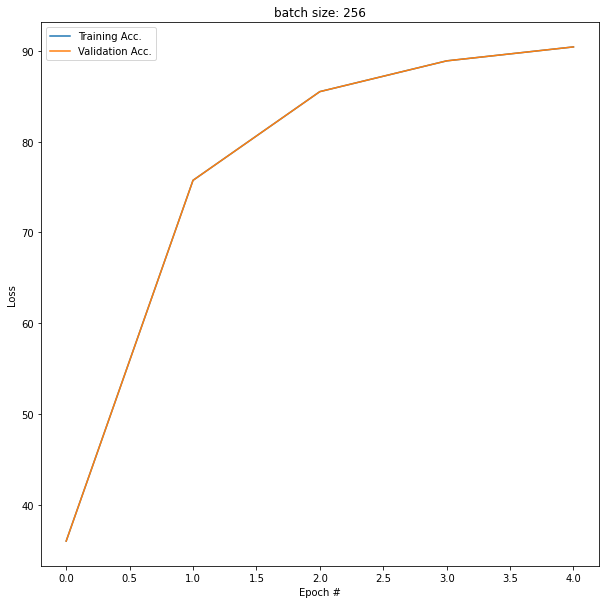

In [25]:
for j, batch_size in enumerate(batch_sizes):
    train_acc_all = train_batch_acc[j]
    val_acc_all = val_batch_acc[j]
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.')
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('batch size: '+str(batch_size))
    plt.show()

#### b) learning rates

In [26]:
lrs = [1e-3,1e-4, 1e-5, 1e-6]

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)


train_batch_acc = []
val_batch_acc = []

for lr in lrs:

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    train_batch_acc.append(train_acc_all)
    val_batch_acc.append(train_acc_all)

Epoch 0: training loss: 2.3036355559031167, accuracy: 13.458333333333334
Epoch 0: val. loss: 2.3036418214757393, val. accuracy: 13.483333333333333
Epoch 1: training loss: 2.3014097537994385, accuracy: 15.558333333333332
Epoch 1: val. loss: 2.301417741369694, val. accuracy: 15.75
Epoch 2: training loss: 2.2990806789398195, accuracy: 17.002083333333335
Epoch 2: val. loss: 2.299091714493772, val. accuracy: 17.066666666666666
Epoch 3: training loss: 2.2966315428415935, accuracy: 17.958333333333336
Epoch 3: val. loss: 2.296651840209961, val. accuracy: 17.816666666666666
Epoch 4: training loss: 2.2940649286905925, accuracy: 18.672916666666666
Epoch 4: val. loss: 2.2940970278800803, val. accuracy: 18.558333333333334
Epoch 0: training loss: 2.303663464864095, accuracy: 9.733333333333333
Epoch 0: val. loss: 2.3028738777688207, val. accuracy: 9.816666666666666
Epoch 1: training loss: 2.3035073903401693, accuracy: 9.733333333333333
Epoch 1: val. loss: 2.3027197604483747, val. accuracy: 9.81666666

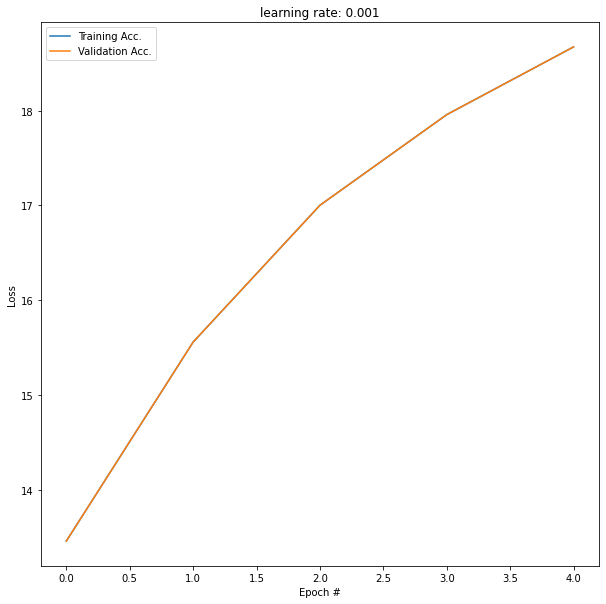

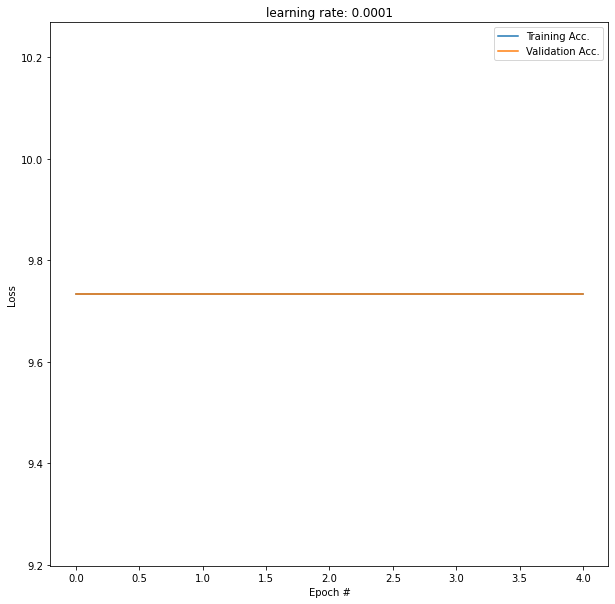

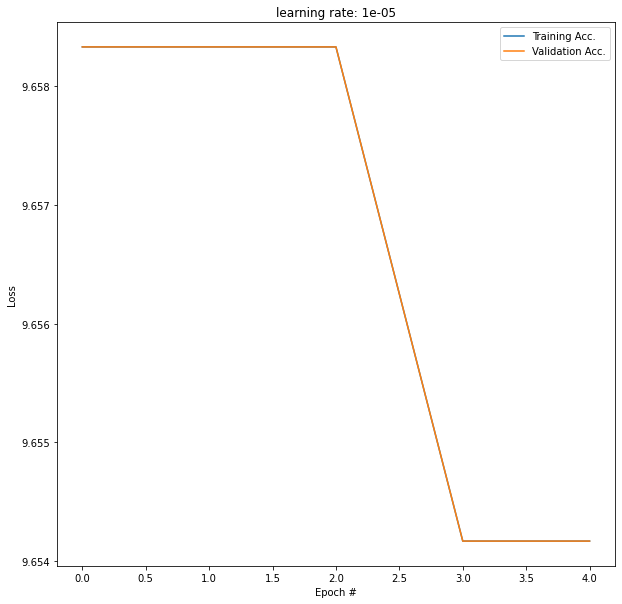

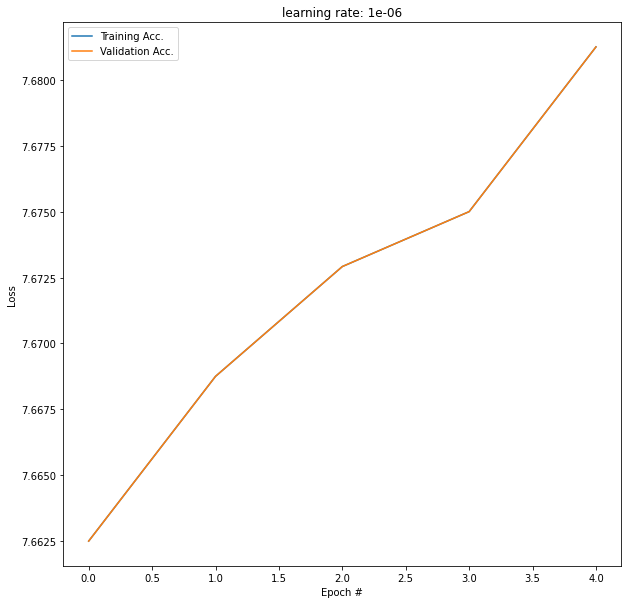

In [27]:
for j, lr in enumerate(lrs):
    train_acc_all = train_batch_acc[j]
    val_acc_all = val_batch_acc[j]
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.')
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('learning rate: '+str(lr))
    plt.show()

A learning rate of 1e-3 did better than 1e-4, 1e-5, or 1e-6.

#### c) activation functions

In [32]:
class NonlinearClassifier_ELU(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
    
class NonlinearClassifier_tanh(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [33]:
models = [NonlinearClassifier(),NonlinearClassifier_ELU(), NonlinearClassifier_tanh()]

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)


train_batch_acc = []
val_batch_acc = []

for model in models:
    nonlinear_model = model
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=1e-5)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    train_batch_acc.append(train_acc_all)
    val_batch_acc.append(train_acc_all)

Epoch 0: training loss: 2.3142473195393882, accuracy: 7.645833333333334
Epoch 0: val. loss: 2.315403864738789, val. accuracy: 7.241666666666667
Epoch 1: training loss: 2.3142171020507813, accuracy: 7.66875
Epoch 1: val. loss: 2.3153725786412016, val. accuracy: 7.258333333333333
Epoch 2: training loss: 2.3141868578592937, accuracy: 7.672916666666667
Epoch 2: val. loss: 2.315341201234371, val. accuracy: 7.3
Epoch 3: training loss: 2.3141567128499347, accuracy: 7.679166666666666
Epoch 3: val. loss: 2.315310003909659, val. accuracy: 7.2749999999999995
Epoch 4: training loss: 2.31412659517924, accuracy: 7.714583333333333
Epoch 4: val. loss: 2.315278786294004, val. accuracy: 7.283333333333333
Epoch 0: training loss: 2.3127003218332924, accuracy: 7.339583333333333
Epoch 0: val. loss: 2.3144219910844845, val. accuracy: 6.966666666666667
Epoch 1: training loss: 2.312535031000773, accuracy: 7.320833333333334
Epoch 1: val. loss: 2.3142536878585815, val. accuracy: 6.933333333333333
Epoch 2: traini

The Tanh activation function is performing better than ReLU and ELU.

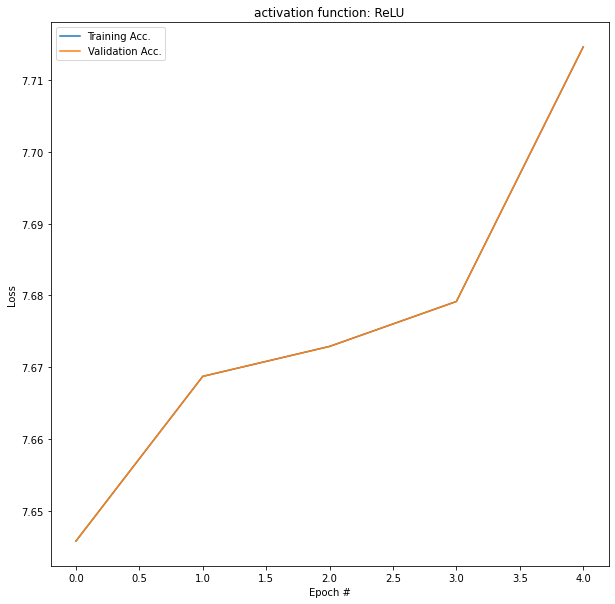

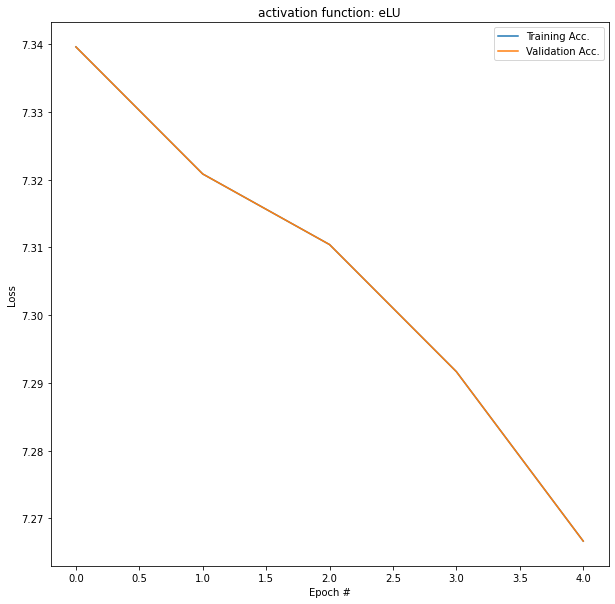

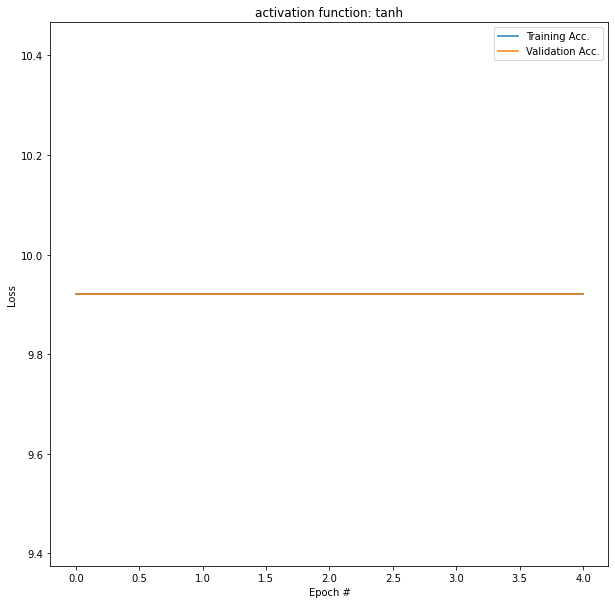

In [34]:
for j, activation in enumerate(['ReLU','eLU','tanh']):
    train_acc_all = train_batch_acc[j]
    val_acc_all = val_batch_acc[j]
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.')
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('activation function: '+activation)
    plt.show()

### 2) Learning rate scheduler

A learning rate scheduler shrinks the learning rate when some condition is met.

For example,
- torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma) decreases the learning rate by a factor of gamma every step_size epochs

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html


- torch.optim.lr.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, threshold=0.0001) decreases the learning rate by a factor of _factor_ if there is no improvement after _patience_ number of epochs, where _threshold_ defines the threshold for considering the new optimum values.

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
